In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
plt.style.use('publication')

In [2]:
def RS(m,c=0.03,delta=0.5):
    
    #Returns Robust Soliton CDF for given parameters
    
    S=c*np.log(m/delta)*np.sqrt(m)
    rho=0.0
    tau=0.0
    r=round(m/S)
    u=np.zeros((1,m))
    
    for d_iter in range(m):
        d=float(d_iter+1)
        if d==1:
            rho=1/float(m)
        else:
            rho=1/(d*(d-1))
        if d>=1 and d<r:
            tau=1/(d*r)
        elif d==r:
            tau=np.log(S/delta)/r
        else:
            tau=0
        u[0][d_iter]=tau+rho
        
    u=u/np.sum(u)
    return np.ravel(u)

In [3]:
def get_tail(vect):
    probs, bin_edges = np.histogram(vect,bins=20,density=False)
    tail = np.cumsum(probs[::-1])[::-1]/vect.shape[0]
    return tail,bin_edges

In [4]:
def get_worker_rows(worker_num,start_time):
    
    worker_dict = {}
    time_key = start_time
    
    for ctr in range(num_workers//sr_deg):
        
        d = np.random.choice(num_workers, replace=True, p=u)
        time_key += comp_time*d
        worker_dict[time_key] = np.random.choice(num_workers, size=d, replace=False, p=None)
        
    return worker_dict

In [5]:
comp_time = 0.005
exp_rate = 0.2
num_workers = 1000
num_trials = 100
sr_deg = 10 #Used to equalize average worker load between LT and SR codes
u = RS(num_workers)

In [6]:
def lt_simulator(times):
  
    worker_dicts_list = [get_worker_rows(worker_num,times[worker_num]) for worker_num in range(num_workers)]
    worker_dict_all = {key: val for worker_dict in worker_dicts_list for key, val in worker_dict.items()}
    
    time_list = sorted(worker_dict_all.keys())
    dec_num = 0
    dec_set = set()
    neighbours = {}
    visited = []
    
    for (i,t) in enumerate(time_list):
        
        dec_sym = worker_dict_all[t]
        
        proc_sym = set([ind for ind in dec_sym if ind not in dec_set]) #Remove decoded symbols
        visited.append(proc_sym)
        
        if len(proc_sym) == 0:
            continue #No useful information

        for node in proc_sym:
            
            #Updating neighbours
            if node in neighbours:
                neighbours[node].append(i)
            else:
                neighbours[node] = [i]
        
        if len(proc_sym) == 1:
            
            #New degree 1 symbol
            ripple_node = proc_sym.pop()
            ripple = [ripple_node]
            
            while ripple:
                
                node = ripple.pop()
                
                if node in dec_set:
                    #Already processed
                    continue
                
                #Decode degree 1 symbol
                dec_set.add(node)
                dec_num += 1
                if dec_num == num_workers:
                    print (i)
                    return t
                
                
                for prev_ind in neighbours[node]:
                    
                    #Process neighbours
                    if node in visited[prev_ind]:
                        visited[prev_ind].remove(node)
                        if len(visited[prev_ind]) == 1:
                            new_node = visited[prev_ind].pop()
                            ripple.append(new_node)
    
    print ('ERROR')
    return -1

In [7]:
LT_times = []

In [8]:
for trial in range(num_trials):
    if trial % 10 == 0:
        print (trial)
#     setup_times = np.random.exponential(scale=1/exp_rate,size=num_workers)
    setup_times = 1.0+np.random.pareto(a=1,size=num_workers)
    LT_times.append(lt_simulator(setup_times))
    #Sum-Recovery

0
2347
2320
2848
2674
2413
2375
2556
2964
2281
1970
10
2041
2046
2549
2023
2065
2066
1914
2399
2567
2316
20
2274
2701
2504
2328
2383
1944
2427
2562
2522
2194
30
2258
2541
2008
2284
2222
2250
2280
2170
1972
2009
40
1980
2610
2174
2463
2056
2273
2405
1951
2703
2271
50
2300
1831
1933
1845
1927
2335
2104
2078
2965
2636
60
2189
2156
2697
2172
1885
2103
2049
2450
2826
2594
70
2209
2556
2068
2332
2090
2187
2901
2294
2993
2100
80
2176
1915
2255
1955
2369
2050
2620
2455
1937
2594
90
2708
2025
2423
2507
2352
2951
2196
2347
2201
1693


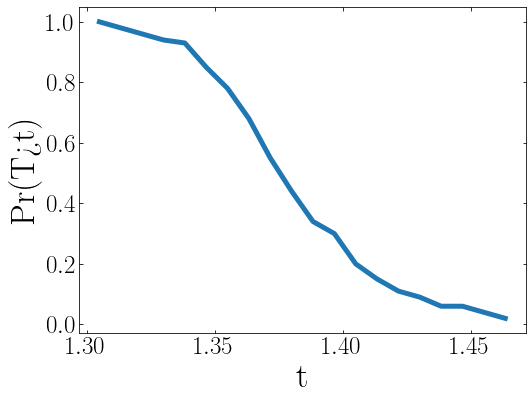

In [9]:
plt.figure()
tail, bin_edges = get_tail(np.asarray(LT_times))
plt.plot(bin_edges[:-1],tail)
plt.xlabel('t')
plt.ylabel('Pr(T>t)')
plt.show()

In [10]:
with open('LT_times_par.pkl', 'wb') as f:
    pickle.dump(LT_times, f)